# imports and setup

In [1]:
%autocall 2

Automatic calling is: Full


In [2]:
import numpy as np
from IPython.display import display, IFrame, Image, HTML
import os
import csv
import glob

In [3]:
import matplotlib.pyplot as plt
from scipy import sparse

from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
from ipywidgets import VBox, HBox, FloatSlider
import ipywidgets as widgets

In [4]:
%matplotlib -l

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'webagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [5]:
%matplotlib widget

# vowelcharts and vowel PCA mode coefficients

Story, Brad H., Houri K. Vorperian, Kate Bunton, and Reid B. Durtschi. 2018. “An Age-Dependent Vocal Tract Model for Males and Females Based on Anatomic Measurements.” The Journal of the Acoustical Society of America 143 (5): 3079.

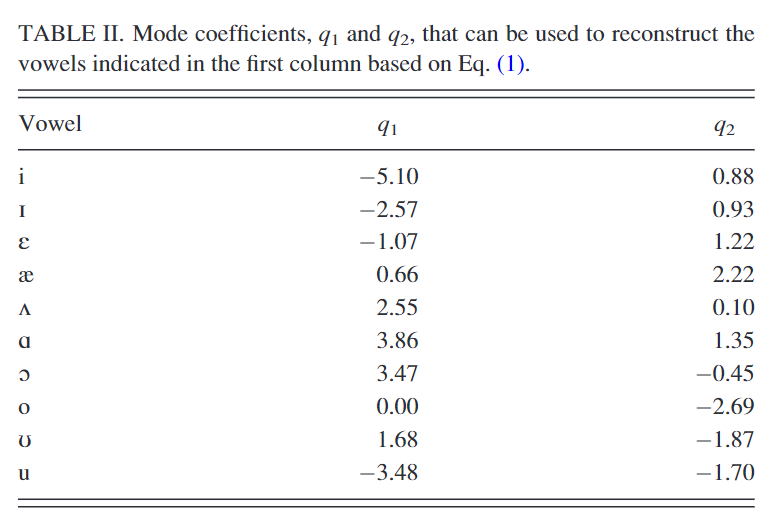

In [6]:
Image('voweltypes.png', width = 500)

In [7]:
vowelchart = {'ease': dict(place = ['front', 'close'], q1 = -5.1, q2 = 0.88), 
              'his': dict(place = ['front', 'close-mid-more'], q1 = -2.57, q2 = 0.93), 
              'then': dict(place = ['front', 'open-mid'], q1 = -1.07, q2 = 1.22), 
              'act': dict(place = ['front', 'open-more'], q1 = 0.66, q2 = 2.22),
              'must': dict(place = ['back', 'open-mid'], q1 = 2.55, q2 = 0.10), 
              'art': dict(place = ['back', 'open'], q1 = 3.86, q2 = 1.35),
              'aught': dict(place = ['back', 'open-mid'], q1 = 3.47, q2 = -0.45),
              'know': dict(place = ['back', 'close-mid'], q1 = 0.00, q2 = -2.69),
              'would': dict(place = ['back-central', 'close-mid-more'], q1 = 1.68, q2 = -1.87),
              'who': dict(place = ['back', 'close'], q1 = -3.48, q2 = -1.70)}

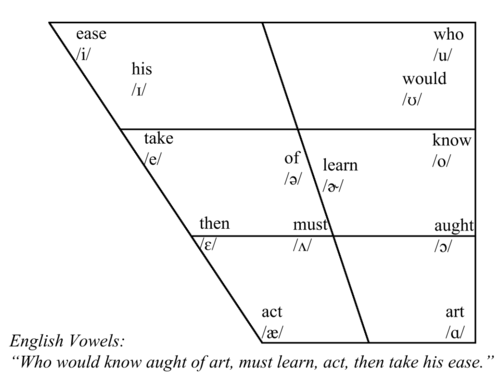

In [8]:
Image("EnglishVowels.png")

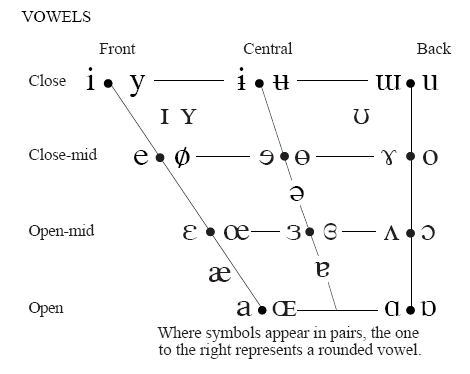

In [9]:
Image('https://www.internationalphoneticassociation.org/sites/default/files/vowels.gif')

# load data

vocal tract area function from first two PCA modes: s = sex, a = age, v = vowel

$$A_x(s, a, v) = \pi/4 \left[ \Omega(s, a) + q_1(v) \phi_1(s, a) + q_2(v) \phi_2(s, a)\right]^2 $$

In [10]:
vocaltracts = dict(female = None, male = None)

datafiles = dict(female = 'Story2018data - Female.csv',
                 male = 'Story2018data - Male.csv')

for sex in datafiles.keys():
  with open(datafiles[sex]) as csvfile:
    csvreader = csv.reader(csvfile)

    ages = csvreader.__next__()
    annotations = csvreader.__next__()

    rows = []

    for row in csvreader:
      if row[0].isdigit():
        rows.append([float(e) for e in row[1:]])
      elif row[0].startswith('L(i)'):
        Li = [float(e) for e in row[1:] if e]
      elif row[0].startswith('VTL'):
        VTL = [float(e) for e in row[1:] if e]
        
  ages = [age.lower().replace(sex, '').strip() for age in ages if age]

  coeffs = np.array(rows).reshape(-1, len(Li), 3)

  vocaltracts[sex] = {age: dict(vowel = {vowel: None for vowel in vowelchart.keys()}) for age in ages}

  for num, age in enumerate(ages):
    o, p1, p2 = coeffs[:, num, :].T

    vocaltracts[sex][age].update(dict(li = Li[num], vtl = VTL[num]))

    for vowel in vowelchart.keys():
      Ax = np.pi / 4.0 * (o + vowelchart[vowel]['q1'] * p1 + vowelchart[vowel]['q2'] * p2)**2

      # vocaltracts[sex][age] = dict(o = o, p1 = p1, p2 = p2, li = Li[num], vtl = VTL[num], Ax = Ax)
      vocaltracts[sex][age]['vowel'][vowel] = Ax

# create vowel area function

In [11]:
vowelselect = widgets.Dropdown(options = vowelchart.keys(), value = 'ease', description = 'vowel: ')
ageselect = widgets.Dropdown(options = ages, value = 'adult', description = 'age: ')
sexselect = widgets.Dropdown(options = vocaltracts.keys(), value = 'female', description = 'sex: ')

In [13]:
try:
  fig.clear()
  plt.close(fig)
  del fig
except:
  plt.close('all')

plt.ioff()
# plt.ion()

fig = plt.figure(figsize = (11, 5), clear = True)
fig.canvas.header_visible = False

ax = fig.add_subplot()

sex = 'female'
age = 'adult'

v1 = 'act'
NA = len(vocaltracts[sex][age]['vowel'][v1])
Li = vocaltracts[sex][age]['li']

line0 = ax.step(Li * np.arange(NA + 1), np.sqrt(np.hstack((vocaltracts[sex][age]['vowel'][v1], vocaltracts[sex][age]['vowel'][v1][-1:])) / np.pi), 
        Li * np.arange(NA + 1), - np.sqrt(np.hstack((vocaltracts[sex][age]['vowel'][v1], vocaltracts[sex][age]['vowel'][v1][-1:])) / np.pi),
        where = 'post', color = 'b', label = f"{sex} {age}: {v1}")

line = ax.step(Li * np.arange(NA + 1 + 20), np.sqrt(np.hstack((vocaltracts[sex][age]['vowel']['ease'], vocaltracts[sex][age]['vowel']['ease'][-1:], 20*[np.pi])) / np.pi), 
                 Li * np.arange(NA + 1 + 20), - np.sqrt(np.hstack((vocaltracts[sex][age]['vowel']['ease'], vocaltracts[sex][age]['vowel']['ease'][-1:], 20*[np.pi])) / np.pi),
                 where = 'post', color = 'r', label = f"{sex} {age}: ease")

v2 = 'know'
line1 = ax.step(Li * np.arange(NA + 1), np.sqrt(np.hstack((vocaltracts[sex][age]['vowel'][v2], vocaltracts[sex][age]['vowel'][v2][-1:])) / np.pi),
        Li * np.arange(NA + 1), - np.sqrt(np.hstack((vocaltracts[sex][age]['vowel'][v2], vocaltracts[sex][age]['vowel'][v2][-1:])) / np.pi),
        where = 'post', color = 'g', label = f"{sex} {age}: {v2}")

plt.grid(which = 'both')

plt.xlabel('vocal tract location [cm]')
plt.ylabel('area [$cm^2$]')
plt.ylabel('radius [cm]')

plt.xlim(left = 0)
# plt.ylim(bottom = 0)

# hide labels

line0[1].set_label('_')
line[1].set_label('_')
line1[1].set_label('_')

legend = ax.legend()

In [14]:
try:
    del updatefig
    del updatevowelplot
except:
    pass

def updatevowelplot(vowel, age, sex):
    NA = len(vocaltracts[sex][age]['vowel'][vowel])
    Li = vocaltracts[sex][age]['li']

    [l.set_xdata(Li * np.arange(NA + 1 + 20)) for l in line]
    line[0].set_ydata(np.sqrt(np.hstack((vocaltracts[sex][age]['vowel'][vowel], vocaltracts[sex][age]['vowel'][vowel][-1:], 20*[np.pi])) / np.pi))
    line[1].set_ydata(- np.sqrt(np.hstack((vocaltracts[sex][age]['vowel'][vowel], vocaltracts[sex][age]['vowel'][vowel][-1:], 20*[np.pi])) / np.pi))
    [l.set_label(f"{sex} {age}: {vowel}") for l in line]
    line[1].set_label('_')
    
    ax.relim()
    ax.autoscale()
    ax.autoscale_view(scalex = True)

    ax.set_xlim(left = 0)
    # ax.set_ylim(bottom = 0)
    
    ax.legend()

    fig.canvas.draw()

updatefig = interactive_output(updatevowelplot, {'vowel': vowelselect, 'age': ageselect, 'sex': sexselect})

ui = HBox([sexselect, ageselect, vowelselect])

# Display vowel area function for different sexes, ages, and vowels

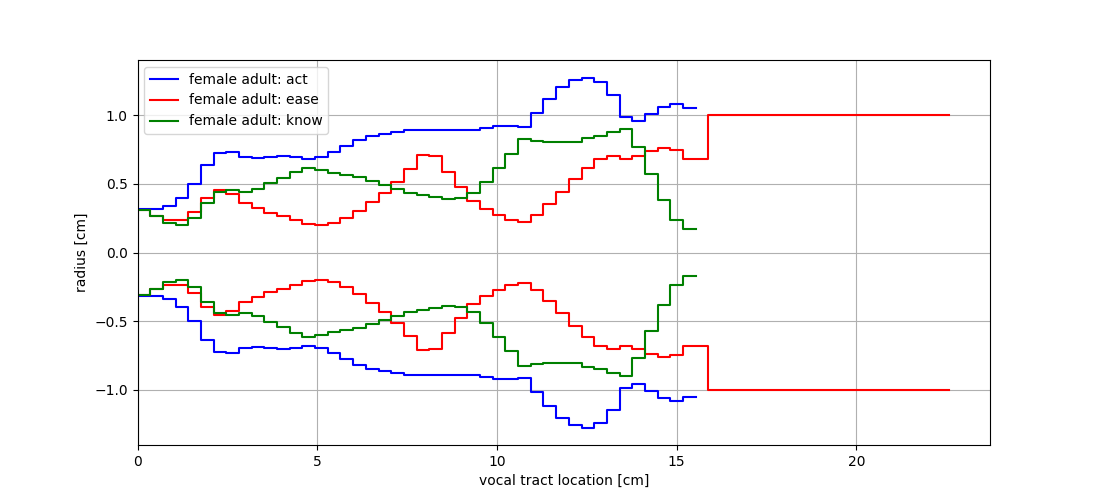

In [15]:
display(ui, fig.canvas)

# F0 ranges

In [ ]:
# Clinical Measurement of Speech and Voice - 2nd edition - Baken and Orlikoff
f0ranges = dict(newborn = dict(ageyear = [0, 1], f0 = [217, 435]),
                toddler = dict(ageyear = [1, 2], f0 = [305, 407]),
                preschool = dict(ageyear = [3, 5], f0 = [137, 322]),
                schoolage = dict(ageyear = [6, 12], f0 = [192, 271]),
                adolescent = dict(ageyear = [13, 17], f0 = []),
                adultfemale = dict(ageyear = [20, 85], f0 = [93, 275]),
                adultmale = dict(ageyear = [21, 85], f0 = [90, 178]),)

In [ ]:
ages

In [ ]:
# Perry, T. L., R. N. Ohde, and D. H. Ashmead. 2001. 
# “The Acoustic Bases for Gender Identification from Children’s Voices.” 
# The Journal of the Acoustical Society of America 109 (6): 2988–98.

f0kids = dict(male = {'adult': 130,
                      '12 yr': 225, 
                      '8 yr': 260, 
                      '4 yr': 260,
                      '0 yr': 260},
              female = {'adult': 225,
                        '12 yr': 225, 
                        '8 yr': 260, 
                        '4 yr': 260,
                        '0 yr': 260})

Image('pitch-age.png', width = 500, height = 500)

In [ ]:
Image('pitch-Titze.png', width = 500, height = 500)

# paper: Wolfe, Fletcher, Smith: Interaction between wind instruments and their players

In [ ]:
IFrame("Wind-Instrument-Overview.pdf", width = 1200, height = 500)

# paper: Story: Acoustic impedance of lengthened tract

In [ ]:
IFrame("Story et al. 2000 - Acoustic impedance of an artificially lengthened and constricted vocal tract.pdf", width = 1200, height = 500)

# paper: Sondhi: speech synthesizer

In [ ]:
IFrame("Sondhi and Schroeter 1987 - A hybrid time-frequency domain articulatory speech synthesizer.pdf", width = 1200, height = 500)

# Compute Impedances and Reflection

In [ ]:
rho = 0.001225 # density of air in kg / cm^3
cair = 344 * 100 # speed of sound in cm/s, all lenghts are in cm

In [ ]:
def compute_K(area_list, dL, fmin = 1, fmax = 1000, df = 1, hardwall = False):

    if not hasattr(area_list, '__iter__'):
        print("Warning: compute_K: area_list must be an iterable, either list or 1D array")
    
    r = 130 * np.pi # rad/s
    Fw = 15 # Hertz
    Ft = 200 # Hertz
    q = 4 # rad/s
    
    Nf = 1 + int((fmax - fmin) / df)
    
    f_sparse = sparse.diags(np.linspace(fmin, fmax, num = Nf))
    w = 2 * np.pi * f_sparse
    
    invterm = sparse.eye(Nf, dtype = np.complex128)
    
    if not hardwall:
        r = r * sparse.eye(Nf)
        Fw = Fw * sparse.eye(Nf)

        alpha = np.sqrt(1j * w * q)

        invterm.setdiag(1 / ((1j * w + r) * 1j * w + (2 * np.pi * Fw)**2).data)
        beta = alpha + 1j * w * (2 * np.pi * Ft)**2 * invterm

        invterm.setdiag(1 / (beta + 1j * w).data)
        gamma = np.sqrt((r + 1j * w) * invterm)

        sigma = gamma * (beta + 1j * w)
    else:
        # hard walled tubes
        # r = 0, beta = 0, alpha = 0
        # gamma = 1
        # sigma = 1j * w
        
        r = 0
        beta = 0
        alpha = 0
        
        gamma = 1.0
        sigma = 1j * w
    
    # cosh(x) = 0.5 * (exp*(x) + exp(-x))
    # expm1(x) = exp(x) - 1
    
    if type(dL) is not list:
        if not hasattr(dL, "__iter__"):
            dL_list = [dL] * len(area_list)

            A = 0.5 * (np.expm1(sigma * dL / cair) + np.expm1(-sigma * dL / cair) + 2 * sparse.eye(Nf))
            D = A

            sinhterm = np.sinh(sigma * dL / cair)
        else:
            dL_list = dL
    elif type(dL) is list:
        dL_list = dL
    elif hasattr(dL, "__iter__"):
        dL_list = dL
    
    if not hardwall:
        invterm.setdiag(1 / (rho * cair * gamma).data)
    else:
        invterm = 1.0

    # initialize K with identity matrix
    K = sparse.identity(2*Nf)

    for Ax, dLx in zip(area_list, dL_list):
        if hasattr(dL, "__iter__"):
            A = 0.5 * (np.expm1(sigma * dLx / cair) + np.expm1(-sigma * dLx / cair) + 2 * sparse.eye(Nf))
            D = A
            sinhterm = np.sinh(sigma * dLx / cair)

        B = - rho * cair * gamma * sinhterm / Ax

        C = - Ax * sinhterm * invterm

        # multiply from right to left: K1, K2 * K1, K3 * K2 * K1, etc, to KN * KN-1 * ... K2 * K1
        K = sparse.bmat([[A, B], [C, D]]) @ K
        
    return f_sparse, K

In [ ]:
def lip_impedance(area_lips, f_sparse):
    Nf = f_sparse.shape[0]
    
    invterm = sparse.eye(Nf, dtype = np.complex128)

    Amouth = area_lips 

    b = np.sqrt(Amouth / np.pi)
    Zm = rho * cair / Amouth

    R = 128 * Zm / (9 * np.pi**2)
    L = 8 * b * Zm / (3 * np.pi * cair)

    w = 2 * np.pi * f_sparse

    invterm.setdiag(np.squeeze(1 / (R * sparse.eye(Nf) + 1j * w * L).data))

    return (1j * w * R * L * invterm)

In [ ]:
def input_impedance(area_list, dL, fmin = 1, fmax = 1000, df = 1, hardwall = False):

    f_sparse, K = compute_K(area_list, dL, fmin = fmin, fmax = fmax, df = df, hardwall = hardwall)
    
    Nf = f_sparse.shape[0]

    Atract = K[:Nf, :Nf]
    Btract = K[:Nf, Nf:]
    Ctract = K[Nf:, :Nf]
    Dtract = K[Nf:, Nf:]

    invterm = sparse.eye(Nf, dtype = np.complex128)
    
    Amouth = area_list[-1] # last entry in list of tublet areas
    
    Zlips = lip_impedance(Amouth, f_sparse)
    
    invterm.setdiag(1 / (Atract - Ctract * Zlips).data)

    return f_sparse, ((Dtract * Zlips - Btract) * invterm)

In [ ]:
def powerreflectioncoeff(Zin_sparse, f_sparse):
    # power reflection and transmission coefficient
    Nf = f_sparse.shape[0]
    
    invterm = sparse.eye(Nf, dtype = np.complex128)
    invterm.setdiag(1 / (Zin_sparse + rho * cair * sparse.eye(Nf)).data)
    
    R = (Zin_sparse - rho * cair * sparse.eye(Nf)) * invterm 

    Rpower = np.abs(R.diagonal())**2

    # Tpower = 1 - Rpower
    
    return R.diagonal(), Rpower # , Tpower

# Resonator Selector widget setup

In [ ]:
class Length(FloatSlider):
    def __init__(self, name, value, **kwargs):
        kwargs['description'] = name
        kwargs['value'] = value
        kwargs['min'] = 1
        kwargs['max'] = 100
        kwargs['step'] = 1
        kwargs['readout_format'] = '.1f'
        kwargs['continuous_update'] = False
        super().__init__(**kwargs)
    
    if False:
        def __repr__(self):
            return(f"{self.description} = {self.value}")
        
class Diameter(FloatSlider):
    def __init__(self, name, value, **kwargs):
        kwargs['description'] = name
        kwargs['value'] = value
        kwargs['min'] = 0.5
        kwargs['max'] = 10
        kwargs['step'] = 0.5
        kwargs['readout_format'] = '.1f'
        kwargs['continuous_update'] = False
        super().__init__(**kwargs)
    
    if False:
        def __repr__(self):
            return(f"{self.description} = {self.value}")

In [ ]:
resonators = dict(nostraw = dict(sections = [dict()]),
                  
                  straight = dict(sections = [dict(L = Length('L [cm]', 100), D = Diameter('D [cm]', 2.5))]),
                  
                  lowpass = dict(sections = [dict(L = Length('L1 [cm]', 33), D = Diameter('D1 [cm]', 2.5)),
                                             dict(L = Length('L2 [cm]', 33), D = Diameter('D2 [cm]', 5.0)), 
                                             dict(L = Length('L3 [cm]', 33), D = Diameter('D3 [cm]', 2.5))]),
                  
                  highpass = dict(sections = [dict(L = Length('L1 [cm]', 50), D = Diameter('D1 [cm]', 2.5)),
                                              dict(L = Length('Lside [cm]', 1), D = Diameter('Dside [cm]', 2)),
                                              dict(L = Length('L2 [cm]', 50), D = Diameter('D2 [cm]', 2.5))]),
                  
                  bandstop = dict(sections = [dict(L = Length('L1 [cm]', 50), D = Diameter('D1 [cm]', 2.5)),
                                              dict(L = Length('Lneck [cm]', 5), D = Diameter('Dneck [cm]', 2)),
                                              dict(L = Length('Lcavity [cm]', 10), D = Diameter('Dcavity [cm]', 4)),
                                              dict(L = Length('L2 [cm]', 50), D = Diameter('D2 [cm]', 2.5))])) # in cm

In [ ]:
# test
compute_K((np.pi/4 * np.array([s['D'].value for s in resonators['lowpass']['sections']])**2), 
          [s['L'].value for s in resonators['lowpass']['sections']], # lengths of sections as a list
          hardwall = True)

In [ ]:
config_nostraw = HBox()

config_straight = HBox([VBox(v) for v in [list(s.values()) for s in resonators['straight']['sections']]])

config_lowpass = HBox([VBox(v) for v in [list(s.values()) for s in resonators['lowpass']['sections']]])

config_highpass = HBox([VBox(v) for v in [list(s.values()) for s in resonators['highpass']['sections']]])

config_bandstop = HBox([VBox(v) for v in [list(s.values()) for s in resonators['bandstop']['sections']]])

config_resonators = [config_nostraw, config_straight, config_lowpass, config_highpass, config_bandstop]

resonatorstack = widgets.Stack(config_resonators, selected_index = 2)

select_resonator = widgets.Dropdown(options = resonators.keys(), value = 'lowpass', description = 'resonator')

widgets.jslink((select_resonator, 'index'), (resonatorstack, 'selected_index'))

config_resonator = widgets.VBox([select_resonator, resonatorstack])

In [ ]:
out = widgets.Output()

@out.capture(clear_output = True, wait = True)
def update_resonator(change):
    print(change['new'])
    print(change['owner'].description)
    
select_resonator.observe(update_resonator, names = 'value')

In [ ]:
for resonator in resonators.keys():
    for section in resonators[resonator]['sections']:
        for v in section.values():
            v.observe(update_resonator, names = 'value')

# Resonator Selector widget

In [ ]:
display(config_resonator)
display(out)

# Calculate impedance functions for all cases

In [ ]:
sex = 'male'
age = 'adult'
vowel = 'who'

dL = vocaltracts[sex][age]['li']

A = vocaltracts[sex][age]['vowel'][vowel]

Amouth = A[-1] # last entry in list of tublet areas

f_sparse, Zin = input_impedance(A, dL)

f = f_sparse.diagonal()
Zvt = Zin.diagonal()

Zlips = lip_impedance(Amouth, f_sparse).diagonal()

R, Rpower = powerreflectioncoeff(Zin, f_sparse)

In [ ]:

def compute_acoustics(sex = 'female', age = 'adult', vowel = 'know'):
    pass

acoustics = dict(f = None)

for sex in vocaltracts.keys():
    acoustics.update({sex: dict()})
    
    for age in vocaltracts[sex].keys():
        acoustics[sex].update({age: dict()})
        
        for vowel in vocaltracts[sex][age]['vowel'].keys():
            dL = vocaltracts[sex][age]['li']
            Avowel = vocaltracts[sex][age]['vowel'][vowel]

            Amouth = Avowel[-1]

            f_sparse, Zin = input_impedance(Avowel, dL)

            f = f_sparse.diagonal()
            Zvt = Zin.diagonal()

            # Zlips = lip_impedance(Amouth, f_sparse).diagonal()

            R, Rpower = powerreflectioncoeff(Zin, f_sparse)

            # acoustics[sex][age].update({vowel: dict(Zvt = None, R = None, Rpower = None)})
            acoustics['f'] = f
            acoustics[sex][age][vowel] = dict(Zvt = Zvt, R = R, Rpower = Rpower)

In [ ]:
acoustics.keys()

In [ ]:
acoustics[sex][age]['ease'].keys()

# Impedance plots

## create impedances plots

In [ ]:
try:
    plt.close(figZ)
except:
    pass

figZ, axZ = plt.subplots(figsize = (11, 5), clear = True)
figZ.canvas.header_visible = False

sex = 'female'
age = 'adult'
vowel = 'ease'

f = acoustics['f']
Zvt = acoustics[sex][age][vowel]['Zvt']

absZline, = axZ.plot(f, np.abs(Zvt), label = '|Z|')

realZline, = axZ.plot(f, np.real(Zvt), label = 'Resistance')
imagZline, = axZ.plot(f, np.imag(Zvt), label = 'Reactance')

axZ.axhline(color = 'k')

axZ.grid(which = 'both')
axZ.set_xlim(left = 0)

axZ.set_xlabel('frequency [Hz]')

axZ.set_title(f"{sex}: {age}: {vowel}")

axZ.legend()

figZ.canvas.draw()

In [ ]:
def update_impedanceplot(vowel, age, sex):
    Zvt = acoustics[sex][age][vowel]['Zvt']
    
    absZline.set_ydata(np.abs(Zvt))
    realZline.set_ydata(np.real(Zvt))
    imagZline.set_ydata(np.imag(Zvt))
    
    axZ.set_title(f"{sex}: {age}: {vowel}")

    axZ.relim()
    axZ.autoscale()
    axZ.autoscale_view(scalex = True)

    axZ.set_xlim(left = 0)
    
    # axZ.legend()

    figZ.canvas.draw()

updatefigZ = interactive_output(update_impedanceplot, {'vowel': vowelselect, 'age': ageselect, 'sex': sexselect})

uiZ = HBox([sexselect, ageselect, vowelselect])

## Display impedance plot

In [ ]:
display(uiZ, figZ.canvas)

# reflection plots

## create reflection plot

In [ ]:
try:
    plt.close(figR)
except:
    pass

figR, axR = plt.subplots(figsize = (11, 5), clear = True)
figR.canvas.header_visible = False

R = acoustics[sex][age][vowel]['R']
Rpower = acoustics[sex][age][vowel]['Rpower']

if True:
    absRline, = axR.plot(f, np.abs(R+1) * 100, label = '100 * |1+R|') # should I plot and work with pi (1 + pr / pi)
    angleRline, = axR.plot(f, np.angle(R+1, deg = True), label = 'angle(1+R)')

R2line, = axR.plot(f, Rpower * 100, label = 'power reflection [percent]')

axR.axhline(color = 'k')
axR.axhline(y = 100, color = 'k')

axR.set_xlim(left = 0)
# axR.set_ylim(bottom = 0, top = 100)

f0line = axR.axvline(x = f0kids[sex][age], color = 'r')

axR.grid(visible = True, which = 'both')

axR.set_xlabel('frequency [Hz]')

axR.set_title(f"{sex}: {age}: {vowel}")

axR.legend()

figR.canvas.draw()

In [ ]:
def update_reflectionplot(vowel, age, sex):
    R = acoustics[sex][age][vowel]['R']
    Rpower = acoustics[sex][age][vowel]['Rpower']
    
    absRline.set_ydata(np.abs(R+1) * 100)
    angleRline.set_ydata(np.angle(R+1, deg = True))
    R2line.set_ydata(Rpower * 100)
    
    axR.set_title(f"{sex}: {age}: {vowel}")

    axR.relim()
    axR.autoscale()
    axR.autoscale_view(scalex = True)

    axZ.set_xlim(left = 0)
    
    f0line.set_xdata(f0kids[sex][age])

    # axZ.legend()

    figR.canvas.draw()

updatefigR = interactive_output(update_reflectionplot, {'vowel': vowelselect, 'age': ageselect, 'sex': sexselect})

uiR = HBox([sexselect, ageselect, vowelselect])

## Display reflection plot

In [ ]:
display(uiR, figR.canvas)

# plot reflection data across vowels or age

In [ ]:
f0kids

In [ ]:
f0ranges

In [ ]:
# axR.axvspan(90, 178, color = 'yellow')

In [ ]:
display(HBox([sexselect, ageselect, vowelselect]))

In [ ]:
sex = sexselect.value
age = ageselect.value
vowel = vowelselect.value

In [ ]:
try:
    plt.close(figIm)
except:
    pass

In [ ]:
figIm, axIm = plt.subplots(figsize = (11, 5), clear = True)
figIm.canvas.header_visible = False

In [ ]:
ageRpower = axIm.imshow(np.flipud(np.array([acoustics[sex][a][vowel]['Rpower'] for a in acoustics[sex].keys()])).T, 
                        aspect = 'auto', origin = 'lower', interpolation = 'nearest')

axIm.grid(which = 'both')

axIm.set_xlabel('age')

agelabels = [a for a in acoustics[sex].keys()]
axIm.set_xticks(range(len(agelabels)), labels = agelabels[::-1])

axIm.set_ylabel('frequency [Hz]')

plt.colorbar(mappable = ageRpower, ax = axIm, location = 'right', label = 'power reflection coefficient')

axIm.set_title(f"{sex}: {vowel}")

figIm.canvas.draw()

display(figIm.canvas)

In [ ]:
try:
    plt.close(figIm2)
except:
    pass

In [ ]:
figIm2, axIm2 = plt.subplots(figsize = (11, 5), clear = True)
figIm2.canvas.header_visible = False

In [ ]:
vowelRpower = axIm2.imshow(np.array([acoustics[sex][age][v]['Rpower'] for v in acoustics[sex][age].keys()]).T, 
                           aspect = 'auto', origin = 'lower', interpolation = 'nearest')

axIm2.grid(which = 'both')

axIm2.set_xlabel('vowels')

vowellabels = [v for v in acoustics[sex][age].keys()]
axIm2.set_xticks(range(len(vowellabels)), labels = vowellabels)

axIm2.set_ylabel('frequency [Hz]')

plt.colorbar(mappable = vowelRpower, ax = axIm2, location = 'right', label = 'power reflection coefficient')

axIm2.set_title(f"{sex}: {age}")

figIm2.canvas.draw()

display(figIm2.canvas)

# calculate filter properties

In [ ]:
IFrame("http://users.cms.caltech.edu/~ps/All.pdf", width = 1200, height = 600)

In [ ]:
display(config_resonator)
display(out)

print("predicted cut-off frequency (1/2 power, -3dB point): ???")

In [ ]:
resonators[select_resonator.value]['sections']

In [ ]:
dL_resonator = np.array([s['L'].value for s in resonators[select_resonator.value]['sections']])
print(dL_resonator)
D_resonator = np.array([s['D'].value for s in resonators[select_resonator.value]['sections']])
print(D_resonator)
A_resonator = np.pi / 4 * D_resonator**2 # in cm^2

In [ ]:
f_sparse_resonator, Zin_resonator = input_impedance(A_resonator, dL_resonator, hardwall = True)
f_resonator = f_sparse_resonator.diagonal()
Z_resonator = Zin_resonator.diagonal()

In [ ]:
Aend = A_resonator[-1] # area for radiation

In [ ]:
R_resonator, Rpower_resonator = powerreflectioncoeff(Zin_resonator, f_sparse_resonator)

In [ ]:
try:
    plt.close(figRes)
except:
    pass

In [ ]:
figRes, axRes = plt.subplots(figsize = (11, 5), clear = True)
figRes.canvas.header_visible = False

In [ ]:

axRes.plot(f_resonator, np.abs(R_resonator) * 100, color = 'blue', label = '100 * |R|') # should I plot and work with pi (1 + pr / pi)

if False:
    ax2 = axRes.twinx()
    ax2.plot(f_resonator, np.angle(R_resonator, deg = True), color = 'orange', label = 'angle(R)')

axRes.plot(f, Rpower_resonator * 100, color = 'green', label = 'power reflection [percent]')

# axRes.axhline(color = 'k')
# axRes.axhline(y = 100, color = 'k')

axRes.set_xlim(left = 0)
# axRes.set_ylim(bottom = 0, top = 100)

axRes.grid(visible = True, which = 'both')

axRes.set_xlabel('frequency [Hz]')

axRes.set_title(f"{select_resonator.value}")

axRes.legend()

figRes.canvas.draw()

In [ ]:
display(figRes.canvas)

In [ ]:
1.5 / (2 * np.pi * 0.06 / 344)

# Lous, Hirschberg 1998 paper

In [ ]:
IFrame("Lous et al. 1998 - A symmetrical two-mass vocal-fold model coupled to vocal tract and trachea, with application to prosthesis design.pdf", width = 1200, height = 500)

\begin{gather}
%$$
Z_1 = \rho c / A_1 
\\
Z_1 U_g(t) = p_1^+(t) - p_1^-(t)
\\
\text{Fourier transform: } \; Z_1 \tilde{U}_g(\omega) = \tilde{p}_1^+(\omega) - \tilde{p}_1^-(\omega)
\\
\text{reflection coefficient in Fourier space:} \; \tilde{R}(\omega) = \frac{\tilde{p}^-}{\tilde{p}^+}
\\
Z_1 \tilde{U}_g(\omega) = \tilde{p}^+ \left(1 - \tilde{R}\right)
%$$
\end{gather}

pressure $p_3$ acting on superior surface of vocal folds:
\begin{gather}
%$$
p_3(t) = p_{3, ac}(t) = p_1^+(t) + p_1^-(t)
\\
\text{Fourier transform: } \; \tilde{p}_3(\omega) = \tilde{p}^+ \left(1 + \tilde{R}(\omega)\right)
\\
\tilde{p}_3(\omega) = \tilde{U}_g(\omega) Z_1 \frac{1 + \tilde{R}(\omega)}{1 - \tilde{R}(\omega)} = \tilde{U}_g(\omega) \frac{\rho c}{A_1} \frac{1 + \tilde{R}(\omega)}{1 - \tilde{R}(\omega)}
%$$
\end{gather}

\begin{gather}
%$$
\tilde{p}_3(\omega) - Z_1 \tilde{U}_g(\omega) = \tilde{R}(\omega) \left( \tilde{p}_3(\omega) + Z_1 \tilde{U}_g(\omega) \right)
\\
\text{Inverse Fourier transform: } \; p_3(t) - Z_1 U_g(t) = R(t) * \left( p_3(t) + Z_1 U_g(t) \right) \text{with the convolution operation} \; f(t) * g(t) = \int{f(y) g(t)}
%$$
\end{gather}

no reflections $\tilde{R}(\omega) = 0 : \tilde{p}_3(\omega) = Z_1 \tilde{U}_g(\omega)$

infinite reflections $\tilde{R}(\omega) = \infty: \tilde{p}_3(\omega) = - Z_1 \tilde{U}_g(\omega)$

unity reflection $\tilde{R}(\omega) = 1: \tilde{p}_3(\omega) \to \infty$

modulus goes to one, phase free: $|\tilde{R}(\omega)| = 1 :$
$$
\tilde{p}_3(\omega) = Z_1 \tilde{U}_g(\omega) \frac{i \sin(\varphi)}{1 - \cos(\varphi)} = -i Z_1 \tilde{U}_g(\omega) \cot(\varphi / 2) = \exp(-i \pi / 2) Z_1 \tilde{U}_g(\omega) \cot(\varphi / 2)
$$

Large coupling of reflected pressure for small $A_1$, compared to what though? Compared to $\tilde{U}_g(\omega)$ and the fraction due to the reflection coefficient

$$
\tilde{R} = \frac{Z_{in} - Z_1}{Z_{in} + Z_1} \Rightarrow \frac{1 + \tilde{R}(\omega)}{1 - \tilde{R}(\omega)} = \frac{Z_{in}(\omega)}{Z_1}
$$

$$
\tilde{p}_3(\omega) = \tilde{U}_g(\omega) Z_{in}(\omega) = Z_1 \tilde{U}_g(\omega) + 2 \tilde{p}_1^-(\omega)
\\
\text{reflected pressure wave component: } \; \tilde{p}_1^-(\omega) = \frac{1}{2} \tilde{U}_g(\omega) \left(Z_{in} - Z_1\right)
$$

**ideal open end**, pressure node (zero), volume flow antinode: $Z_{L} = \frac{p_L}{U_L} = 0$

**closed end**, pressure antinode, volume flow node (zero): $Z_{L} = \infty$

for example: **straight duct theory:**
$$
\frac{Z_{in}}{Z_0} = \frac{Z_L/Z_0 + i \tan(k L)}{1 + i Z_L/Z_0 \tan(k L)}
\\
\tilde{R} = \frac{(Z_L / Z_0 - 1) (\cos(k  L) - i  \sin(k L)) }{ (Z_{L} / Z_{0} + 1) (\cos(k L) + i \sin(k L))} = 
\frac{(Z_L / Z_0 - 1) (1 - i  \tan(k L)) }{ (Z_{L} / Z_{0} + 1) (1 + i \tan(k L))}
$$

**open duct end** (no end correction, no radiation): $Z_{in} = Z_0 i \tan(k L)$, reflection coefficient: 
$$\tilde{R} = \frac{i  \tan(k L) - 1}{i \tan(k L) + 1} = - \exp(-i 2 k L) = - \exp(-i \omega \, 2 L / c) = - \exp(-i \omega \Delta T) = \exp\left[i (\pi - \omega \Delta T)\right] = - \cos(\omega \Delta T) + i \sin(\omega \Delta T)$$

with $\Delta T = \frac{2 L}{c}$ the total round-trip time from entrance to exit back to entrance of the duct

**closed duct end:** $Z_{in} = -i \cot(k L)$, reflection coefficient:
$$\tilde{R} = \frac{1 - i  \tan(k L)}{1 + i \tan(k L)} = \exp(-i 2 k L) = \exp(-i \omega \Delta T) = \cos(\omega \Delta T) - i \sin(\omega \Delta T)$$

open duct end (no end correction, no radiation): 
$$
\tilde{p}_3(\omega) = i Z_1 \tilde{U}_g(\omega) \tan(k L) = i Z_1 \tilde{U}_g \tan(\omega \, L/c) = i Z_1 \tilde{U}_g \tan(\omega \Delta T / 2) 
= Z_1 \tilde{U}_g \frac{i \sin(\omega \Delta T)}{\cos(\omega \Delta T) + 1}
$$ 

closed duct end: 
$$
\tilde{p}_3(\omega) = - i Z_1 \tilde{U}_g(\omega) \cot(k L) = - i Z_1 \tilde{U}_g(\omega) \cot(\omega \Delta T / 2) = Z_1 \tilde{U}_g \frac{i \sin(\omega \Delta T)}{\cos(\omega \Delta T) - 1}
$$

$$
\tilde{R}(\omega) = |\tilde{R}(\omega)| \exp(i \varphi(\omega))
$$

$$
\frac{1 + \tilde{R}(\omega)}{1 - \tilde{R}(\omega)} = \frac{1 - |\tilde{R}|^2 + 2 i |\tilde{R}| \sin(\varphi)}{1 + |\tilde{R}|^2 - 2 |\tilde{R}| \cos(\varphi)}
$$

$$
\varphi = 2 n \pi: \frac{1 + \tilde{R}(\omega)}{1 - \tilde{R}(\omega)} = \frac{1 + |\tilde{R}|}{1 - |\tilde{R}|} \; \text{MAXIMUM}
\\
\varphi = (n + 1) \pi: \frac{1 + \tilde{R}(\omega)}{1 - \tilde{R}(\omega)} = \frac{1 - |\tilde{R}|}{1 + |\tilde{R}|} \; \text{MINIMUM}
\\
\varphi = (n + 1) \pi/2: \frac{1 + \tilde{R}(\omega)}{1 - \tilde{R}(\omega)} = \frac{1 - |\tilde{R}|^2 \pm 2 i |\tilde{R}|}{1 + |\tilde{R}|^2}
$$

$$
\tilde{p}_3(\omega) = \tilde{U}_g(\omega) \frac{\rho c}{A_1} \frac{1 + \tilde{R}(\omega)}{1 - \tilde{R}(\omega)} = \tilde{U}_g(\omega) \frac{\rho c}{A_1} \frac{1 - |\tilde{R}|^2 + 2 i |\tilde{R}| \sin(\varphi)}{1 + |\tilde{R}|^2 - 2 |\tilde{R}| \cos(\varphi)}
$$

In [ ]:
f0ranges

In [ ]:
f0rangesMike = {"infant": dict(female = [440, 590], male = [440, 590]),
                "3": dict(female = [255, 360], male = [255, 360]),
                "8": dict(female = [215, 300], male = [210, 295]),
                "12": dict(female = [200, 280], male = [195, 275]),
                "15": dict(female = [185, 260], male = [135, 205]),
                'adult': dict(female = [175, 245], male = [105, 160])}

In [ ]:
f0rangesMike

In [ ]:
Image("F0ranges.png")

In [ ]:
display(ui, fig.canvas)

In [ ]:
IFrame("McPhailSlides.pdf", width = 1200, height = 600)

In [9]:
IFrame("https://en.wikibooks.org/wiki/Engineering_Acoustics/Noise_control_with_self-tuning_Helmholtz_resonators", width = 1600, height = 700)